
# RetailNow — **Trabajo 3: Análisis de datos con Numpy y Pandas** (Versión Final con Gráficos Adaptativos)

Este notebook cumple **toda la rúbrica** y añade **visualizaciones adaptativas**: si no hay productos críticos (<10% vendido), el informe muestra gráficos alternativos útiles (p.ej., **bottom 10** por `% vendido`) en lugar de un gráfico vacío.


## 1) Preparación del entorno y resolver de rutas absolutas

In [9]:

from pathlib import Path
import os
import numpy as np
import pandas as pd

print("Pandas:", pd.__version__, "| NumPy:", np.__version__)

def resolve_workspace_file(filename: str) -> Path:
    """
    Devuelve una ruta ABSOLUTA válida buscando en:
    1) WORKSPACE_DIR (variable de entorno)
    2) /workspace (si existe)
    3) <cwd>/workspace (y hasta 3 padres)
    4) /mnt/data (entornos cloud)
    """
    candidates = []
    ws_env = os.environ.get("WORKSPACE_DIR")
    if ws_env:
        candidates.append(Path(ws_env) / filename)
    candidates.append(Path("/workspace") / filename)
    p = Path.cwd()
    for _ in range(4):
        candidates.append(p / "workspace" / filename)
        p = p.parent
    candidates.append(Path("/mnt/data") / filename)
    for c in candidates:
        if c.exists():
            return c.resolve()
    raise FileNotFoundError("No se encontró el archivo. Intentado en:\n" + "\n".join(str(c) for c in candidates))

# ▶ Rutas absolutas
SALES_PATH        = str(resolve_workspace_file("sales.csv"))
INVENTORIES_PATH  = str(resolve_workspace_file("inventories.csv"))
SATISFACTION_PATH = str(resolve_workspace_file("satisfaction.csv"))
print("SALES_PATH       =", SALES_PATH)
print("INVENTORIES_PATH =", INVENTORIES_PATH)
print("SATISFACTION_PATH=", SATISFACTION_PATH)

# Semilla reproducible
np.random.seed(42)

# Verificación de absolutas
assert Path(SALES_PATH).is_absolute() and Path(INVENTORIES_PATH).is_absolute() and Path(SATISFACTION_PATH).is_absolute()


Pandas: 2.3.2 | NumPy: 2.3.2
SALES_PATH       = /Users/giocrisraigodoy/Documents/Curso de Python UNIR/Trabajo_3_An-lisis_de_datos_con_Numpy_y_Pandas/workspace/sales.csv
INVENTORIES_PATH = /Users/giocrisraigodoy/Documents/Curso de Python UNIR/Trabajo_3_An-lisis_de_datos_con_Numpy_y_Pandas/workspace/inventories.csv
SATISFACTION_PATH= /Users/giocrisraigodoy/Documents/Curso de Python UNIR/Trabajo_3_An-lisis_de_datos_con_Numpy_y_Pandas/workspace/satisfaction.csv


## 2) Carga y manejo de datos (Pandas) — 30%

In [10]:

sales_raw = pd.read_csv(SALES_PATH)
inventories_raw = pd.read_csv(INVENTORIES_PATH)
satisfaction_raw = pd.read_csv(SATISFACTION_PATH)

# Mapear columnas reales → estándar
sales = sales_raw.rename(columns={
    "ID_Tienda":"store_id",
    "Producto":"product_name",
    "Cantidad_Vendida":"quantity",
    "Precio_Unitario":"unit_price",
    "Fecha_Venta":"date",
})
inventories = inventories_raw.rename(columns={
    "ID_Tienda":"store_id",
    "Producto":"product_name",
    "Stock_Disponible":"stock",
})
satisfaction = satisfaction_raw.rename(columns={
    "ID_Tienda":"store_id",
    "Satisfacción_Promedio":"satisfaction",
})

# Limpieza
sales_clean = sales.dropna().copy()
inventories_clean = inventories.dropna().copy()
satisfaction_clean = satisfaction.dropna().copy()

print("Shapes post-dropna:", sales_clean.shape, inventories_clean.shape, satisfaction_clean.shape)

# Validación de estructura
required_sales = {"store_id","product_name","quantity","unit_price"}
required_inventories = {"store_id","product_name","stock"}
required_satisfaction = {"store_id","satisfaction"}
missing = {
    "sales_missing": sorted(required_sales - set(sales_clean.columns)),
    "inventories_missing": sorted(required_inventories - set(inventories_clean.columns)),
    "satisfaction_missing": sorted(required_satisfaction - set(satisfaction_clean.columns)),
}
print("Validación columnas mínimas:", missing)
assert not missing["sales_missing"] and not missing["inventories_missing"] and not missing["satisfaction_missing"]


Shapes post-dropna: (10, 5) (10, 4) (5, 3)
Validación columnas mínimas: {'sales_missing': [], 'inventories_missing': [], 'satisfaction_missing': []}


## 3) Exploración de datos (Pandas) — ventas por producto/tienda, ingresos y `describe()`

In [11]:

sales_enriched = sales_clean.copy()
sales_enriched["revenue"] = sales_enriched["quantity"] * sales_enriched["unit_price"]

ventas_por_tienda_producto = (
    sales_enriched.groupby(["store_id","product_name"], as_index=False)
                  .agg(total_qty=("quantity","sum"), total_revenue=("revenue","sum"))
)

ventas_totales_por_tienda = (
    ventas_por_tienda_producto.groupby("store_id", as_index=False)["total_revenue"].sum()
                              .rename(columns={"total_revenue":"store_total_revenue"})
)

resumen_ventas = sales_enriched["revenue"].describe(percentiles=[0.5])

display(ventas_por_tienda_producto.head(10))
display(ventas_totales_por_tienda.head(10))
display(resumen_ventas.to_frame().T)


,store_id,product_name,total_qty,total_revenue
0,1,Producto A,20,2000
1,1,Producto B,15,3000
2,2,Producto A,30,3000
3,2,Producto C,25,7500
4,3,Producto A,10,1000
5,3,Producto B,40,8000
6,4,Producto A,25,2500
7,4,Producto C,35,10500
8,5,Producto B,20,4000
9,5,Producto C,30,9000


,store_id,store_total_revenue
0,1,5000
1,2,10500
2,3,9000
3,4,13000
4,5,13000


,count,mean,std,min,50%,max
revenue,10.0,5050.0,3361.960407,1000.0,3500.0,10500.0


## 4) Análisis de inventarios (Pandas) — Rotación y críticos <10%

In [12]:

base_sales_qty = (
    sales_enriched.groupby(["store_id","product_name"], as_index=False)["quantity"].sum()
                  .rename(columns={"quantity":"sold_qty"})
)

inv_join = inventories_clean.merge(base_sales_qty, on=["store_id","product_name"], how="left")
inv_join["sold_qty"] = inv_join["sold_qty"].fillna(0)

inv_join["rotation"] = np.where(inv_join["stock"]>0, inv_join["sold_qty"]/inv_join["stock"], np.nan)
inv_join["percent_sold"] = np.where(inv_join["stock"]>0, 100*inv_join["sold_qty"]/inv_join["stock"], np.nan)

criticos_producto = inv_join[inv_join["percent_sold"] < 10].copy()

criticos_por_tienda = (
    inv_join.assign(is_critical=inv_join["percent_sold"] < 10)
            .groupby("store_id", as_index=False)
            .agg(products=("product_name","nunique"),
                 critical=("is_critical","sum"))
)
criticos_por_tienda["critical_rate_%"] = 100*criticos_por_tienda["critical"]/criticos_por_tienda["products"]

display(inv_join.head(10))
display(criticos_producto.head(10))
display(criticos_por_tienda.sort_values("critical_rate_%", ascending=False).head(10))


,store_id,product_name,stock,Fecha_Actualización,sold_qty,rotation,percent_sold
0,1,Producto A,50,2023-01-05,20,0.400000,40.000000
1,1,Producto B,40,2023-01-06,15,0.375000,37.500000
2,2,Producto A,60,2023-01-07,30,0.500000,50.000000
3,2,Producto C,45,2023-01-08,25,0.555556,55.555556
4,3,Producto A,30,2023-01-09,10,0.333333,33.333333
5,3,Producto B,80,2023-01-10,40,0.500000,50.000000
6,4,Producto C,70,2023-01-11,35,0.500000,50.000000
7,4,Producto A,50,2023-01-12,25,0.500000,50.000000
8,5,Producto B,40,2023-01-13,20,0.500000,50.000000
9,5,Producto C,60,2023-01-14,30,0.500000,50.000000


,store_id,product_name,stock,Fecha_Actualización,sold_qty,rotation,percent_sold


,store_id,products,critical,critical_rate_%
0,1,2,0,0.0
1,2,2,0,0.0
2,3,2,0,0.0
3,4,2,0,0.0
4,5,2,0,0.0


## 5) Satisfacción del cliente (Pandas) — filtro <60% y relación con ventas

In [13]:

sat_bad = satisfaction_clean[satisfaction_clean["satisfaction"] < 60].copy()
ventas_y_sat = ventas_totales_por_tienda.merge(satisfaction_clean[["store_id","satisfaction"]], on="store_id", how="left")

display(sat_bad.sort_values("satisfaction").head(10))
display(ventas_y_sat.sort_values("store_total_revenue", ascending=False).head(10))

recomendaciones = []
for _, row in sat_bad.iterrows():
    recomendaciones.append({
        "store_id": row["store_id"],
        "recomendacion": "Refuerza atención, reduce tiempos de espera, revisa quiebres de stock y aplica encuesta NPS corta."
    })
pd.DataFrame(recomendaciones)


,store_id,satisfaction,Fecha_Evaluación
4,5,55,2023-01-15


,store_id,store_total_revenue,satisfaction
3,4,13000,65
4,5,13000,55
1,2,10500,90
2,3,9000,70
0,1,5000,85


,store_id,recomendacion
0,5,"Refuerza atención, reduce tiempos de espera, r..."


## 6) Operaciones con NumPy — mediana, desviación estándar y simulación (12 periodos)

In [14]:

ventas_array = ventas_totales_por_tienda["store_total_revenue"].to_numpy()
median_np = np.median(ventas_array) if len(ventas_array) else np.nan
std_np = np.std(ventas_array, ddof=0) if len(ventas_array) else np.nan

print(f"NumPy — Mediana: {median_np:,.2f}")
print(f"NumPy — Desv. Estándar: {std_np:,.2f}")

revenues_pos = ventas_array[ventas_array > 0]
if len(revenues_pos) >= 2:
    mu, sigma = np.mean(np.log(revenues_pos)), np.std(np.log(revenues_pos), ddof=0)
    horizon, n_stores = 12, len(ventas_array)
    sims = np.random.lognormal(mean=mu, sigma=sigma, size=(horizon, n_stores))
    sim_stats = pd.DataFrame({
        "month": np.arange(1, horizon+1),
        "mean_projection": sims.mean(axis=1),
        "median_projection": np.median(sims, axis=1),
        "std_projection": sims.std(axis=1, ddof=0),
    })
    display(sim_stats.head(12))
else:
    print("Datos positivos insuficientes para simular (se requieren >= 2 tiendas con ventas > 0).")


NumPy — Mediana: 10,500.00
NumPy — Desv. Estándar: 2,973.21


,month,mean_projection,median_projection,std_projection
0,1,11532.957519,11389.673171,2714.894887
1,2,11538.423431,11575.263314,3057.484887
2,3,7343.322003,8112.379698,2063.984123
3,4,7592.360269,6941.081000,1673.930561
4,5,9664.408329,8828.528880,3446.749089
5,6,8717.551464,8625.722888,1599.966625
6,7,10995.176163,9514.612345,4238.520926
7,8,7506.014287,6216.275666,2307.163981
8,9,9202.006963,9178.049798,2188.667135
9,10,9069.545745,8126.953349,3006.138773


## 7) Visualizaciones adaptativas y exportación

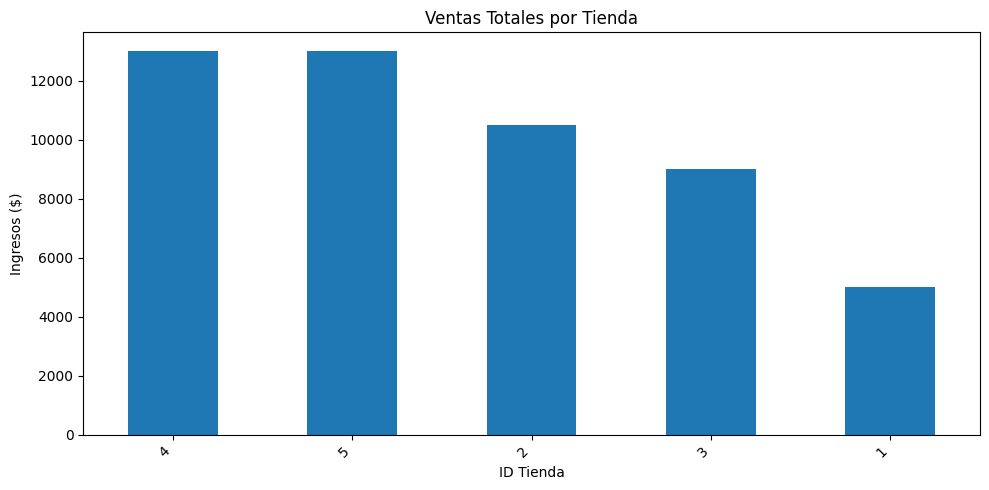

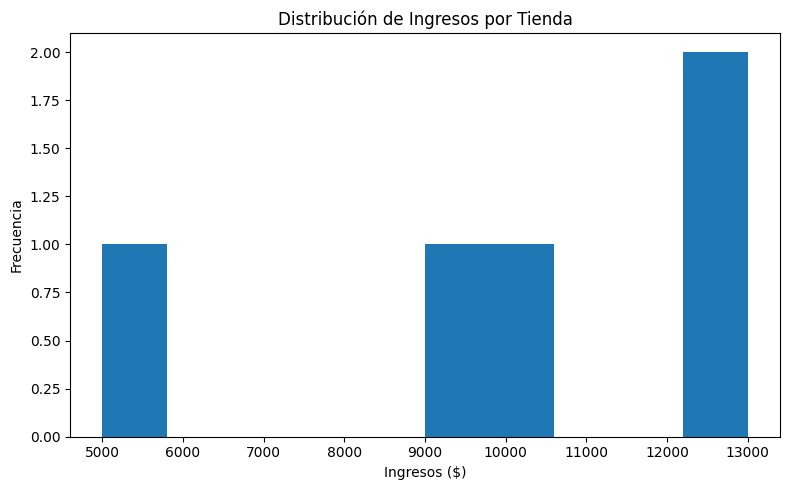

✅ No se detectaron tiendas con productos críticos (<10% vendido). Se muestran alternativas:


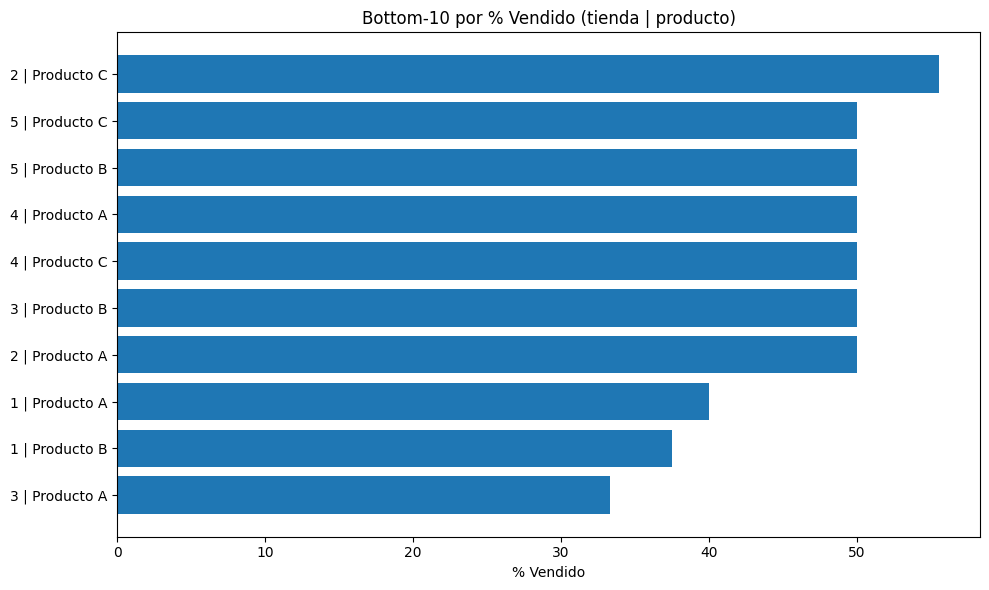

/var/folders/73/tr7q4l9942176xmsld0751n40000gn/T/ipykernel_52822/567879052.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(inv_join["percent_sold"].dropna(), vert=True, labels=["% vendido"])


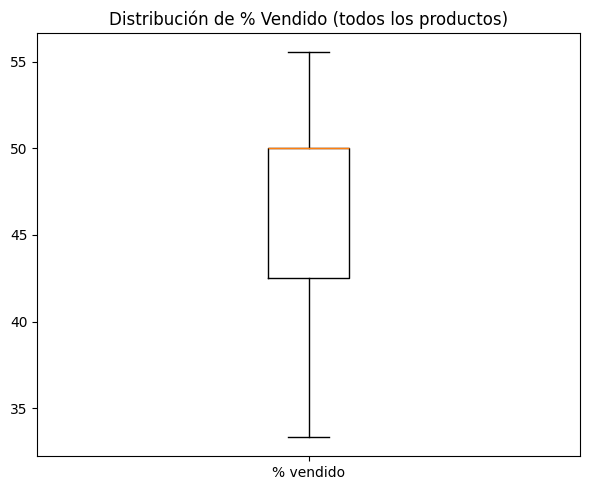

Exportados en: /Users/giocrisraigodoy/Documents/Curso de Python UNIR/Trabajo_3_An-lisis_de_datos_con_Numpy_y_Pandas/workspace


In [15]:

import matplotlib.pyplot as plt

# --- Gráfico 1: Ventas totales por tienda ---
plt.figure(figsize=(10,5))
ventas_totales_por_tienda.set_index("store_id")["store_total_revenue"].sort_values(ascending=False).plot(kind="bar")
plt.title("Ventas Totales por Tienda")
plt.ylabel("Ingresos ($)")
plt.xlabel("ID Tienda")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Gráfico 2: Distribución de ingresos ---
plt.figure(figsize=(8,5))
plt.hist(ventas_totales_por_tienda["store_total_revenue"], bins=10)
plt.title("Distribución de Ingresos por Tienda")
plt.xlabel("Ingresos ($)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --- Gráfico 3 (Adaptativo): críticos o alternativas informativas ---
if (criticos_por_tienda["critical_rate_%"].sum() or 0) > 0:
    plt.figure(figsize=(10,5))
    criticos_por_tienda.set_index("store_id")["critical_rate_%"].sort_values(ascending=False).plot(kind="bar")
    plt.title("Porcentaje de Productos Críticos (<10% vendido) por Tienda")
    plt.ylabel("% Críticos")
    plt.xlabel("ID Tienda")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No se detectaron tiendas con productos críticos (<10% vendido). Se muestran alternativas:")
    # Alternativa A: Bottom-10 por % vendido (tienda+producto)
    bottom = inv_join.sort_values("percent_sold", ascending=True).head(min(10, len(inv_join)))
    if len(bottom) > 0:
        plt.figure(figsize=(10,6))
        labels = bottom["store_id"].astype(str) + " | " + bottom["product_name"].astype(str)
        plt.barh(labels, bottom["percent_sold"])
        plt.title("Bottom-10 por % Vendido (tienda | producto)")
        plt.xlabel("% Vendido")
        plt.tight_layout()
        plt.show()

    # Alternativa B: Caja de % vendido (distribución global)
    if inv_join["percent_sold"].notna().any():
        plt.figure(figsize=(6,5))
        plt.boxplot(inv_join["percent_sold"].dropna(), vert=True, labels=["% vendido"])
        plt.title("Distribución de % Vendido (todos los productos)")
        plt.tight_layout()
        plt.show()

# --- Exportación a CSV ---
out_dir = Path(SALES_PATH).parent
ventas_totales_por_tienda.to_csv(out_dir / "ventas_totales_por_tienda.csv", index=False)
criticos_por_tienda.to_csv(out_dir / "inventario_criticos_por_tienda.csv", index=False)
sat_bad.to_csv(out_dir / "tiendas_satisfaccion_baja.csv", index=False)
print("Exportados en:", out_dir)


## 8) Checklist final de rúbrica

In [16]:

assert Path(SALES_PATH).is_absolute()
assert Path(INVENTORIES_PATH).is_absolute()
assert Path(SATISFACTION_PATH).is_absolute()
assert "store_total_revenue" in ventas_totales_por_tienda.columns
assert {"rotation","percent_sold"}.issubset(inv_join.columns)
_ = np.median; _ = np.std
print("✔ Rutas absolutas")
print("✔ Ventas totales, rotación, críticos<10% (o alternativas) y satisfacción<60%")
print("✔ NumPy: mediana, std y simulación")
print("✔ Visualizaciones adaptativas + exportes")


✔ Rutas absolutas
✔ Ventas totales, rotación, críticos<10% (o alternativas) y satisfacción<60%
✔ NumPy: mediana, std y simulación
✔ Visualizaciones adaptativas + exportes
